# **Testing The Model**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time, sys, os

import cv2
import opencv_transforms.transforms as OTT
import dataloader 

# For everything
import torch
import torch.nn as nn
import torchvision.utils as vutils

# For our model
import models
import torchvision.models

# To ignore warning
import warnings
warnings.simplefilter("ignore", UserWarning)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device=='cuda':
    print("The gpu to be used : {}".format(torch.cuda.get_device_name(0)))
else:
    print("No gpu detected")

The gpu to be used : GeForce GTX 1660


# **Loading The Dataset**

In [2]:
with torch.no_grad():
    netC2S = models.Color2Sketch(pretrained=True).to(device)
    netC2S.eval()

Loading pretrained Color2Sketch model... Done!


In [3]:
batch_size = 1
numberofclust = 9

transforms_the_val_dataset = OTT.Compose([
    OTT.Resize(512),
    ])
open_val_dataset = dataloader.Read_Dataset_Pair_images('./dataset/val', transforms_the_val_dataset, netC2S, numberofclust)
load_val_dataset = torch.utils.data.DataLoader(open_val_dataset, batch_size=batch_size, shuffle=False)
print("The size of the validation data is : {}".format(len(open_val_dataset)))


The size of the validation data is : 299


In [4]:
print('Loading Test data...', end=' ')
transforms_the_test_dataset = OTT.Compose([
    OTT.Resize(512),
    ])
open_test_dataset = dataloader.Read_Dataset_image('/dataset/test', transforms_the_test_dataset, netC2S, numberofclust)
load_test_dataset = torch.utils.data.DataLoader(open_test_dataset, batch_size=batch_size, shuffle=False)
print("Test data size : {}".format(len(open_test_dataset)))


Loading Test data... Test data size : 1


In [5]:
print('Loading Reference data...', end=' ')
transforms_the_reference_dataset = OTT.Compose([
    OTT.Resize(512),
    ])
open_reference_dataset = dataloader.Read_Dataset_image('/dataset/reference', transforms_the_reference_dataset, netC2S, numberofclust)
load_reference_dataset = torch.utils.data.DataLoader(open_reference_dataset, batch_size=1, shuffle=False)
refer_batch = next(iter(load_reference_dataset))
print("Reference data size : {}".format(len(open_reference_dataset)))

Loading Reference data... Reference data size : 1


## Extracting Features 

In [6]:
Iterationbatch = iter(load_reference_dataset)

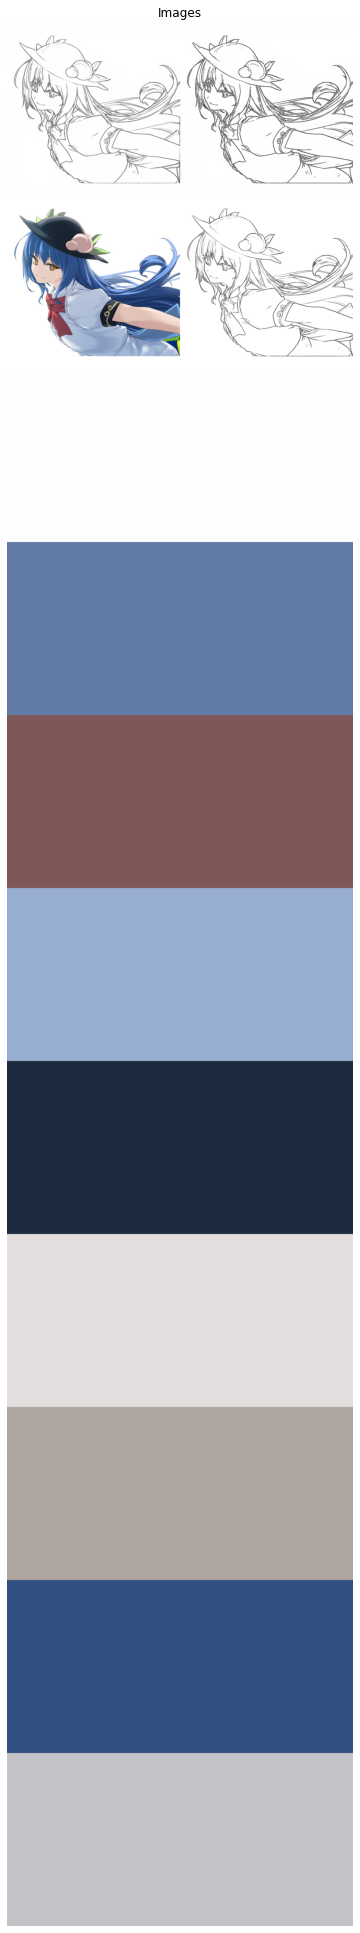

In [7]:
t_b = next(Iterationbatch)
e_img = t_b[0]
c_img = t_b[1]
list_of_c = t_b[2]

plt.figure(figsize=(10, 35))
result =torch.cat([e_img, c_img] + list_of_c,dim=-2)

plt.imshow(np.transpose(vutils.make_grid(result, nrow=6, padding=5, normalize=True).cpu(),(1,2,0)))
plt.axis("off")
plt.title("Images")
plt.show()

# Loading the Model

In [8]:
nc = 3 * (numberofclust + 1)
network_of_skecth = models.Sketch2Color(nc=nc, pretrained=True).to(device) 

num_params = sum(p.numel() for p in network_of_skecth.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))

torch.backends.cudnn.benchmark = True

Loading pretrained Sketch2Color model... Done!
Number of parameters: 63504297


# Results Of The Model

In [9]:
testiterationbatch=iter(load_test_dataset)

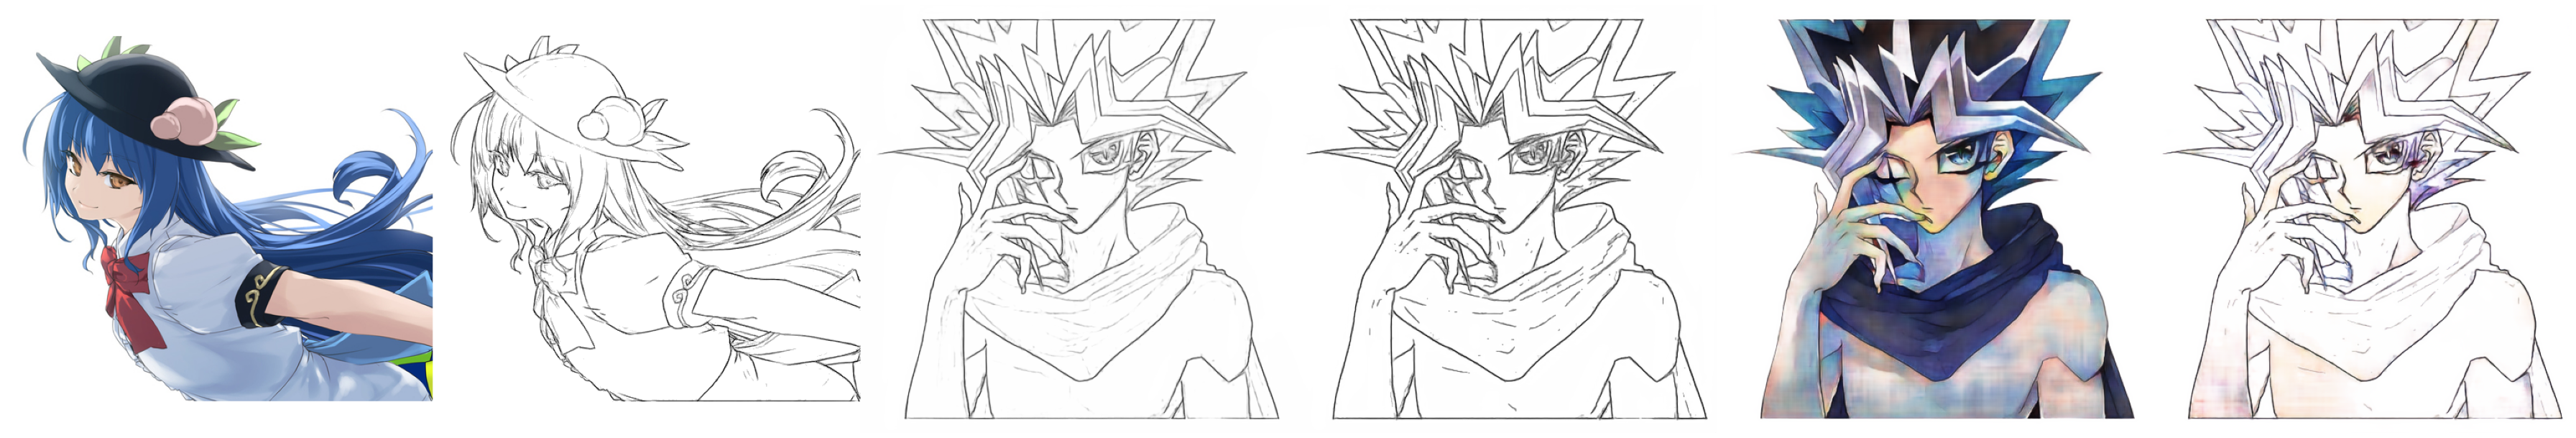

In [10]:
network_of_skecth.eval()
t_b = next(testiterationbatch)

with torch.no_grad():
    
    e = t_b[0].to(device)
    r = t_b[1].to(device)
    reference = refer_batch[1].to(device)
    color_palette = refer_batch[2]
    np_tensor = torch.cat([e.cpu()]+color_palette, dim=1).to(device)
    f = network_of_skecth(np_tensor)
    result = torch.cat((reference, e, f), dim=-1).cpu()
    
    plt.figure(figsize=(64,64))    
    plt.imshow(vutils.make_grid(result, nrow=1, padding=5, normalize=True).cpu().permute(1,2,0))    
    plt.axis("off")